Initial attempt at data processing for LDA
==
Loads a DESI image mzML file and processes it into binned bin x pixel numpy array

In [122]:
import numpy as np
import pylab as plt
import pymzml
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [369]:
import sys
sys.path.append('/Users/simon/git/inklda/code/')
from lda import LDA

In [123]:
filename = '/Users/simon/Dropbox/MS_Ink_Data/Alphabet/abcdefgh_1.mzML'
run = pymzml.run.Reader(filename, MS1_Precision=5e-6)
nScans = run.getSpectrumCount()
print "Loaded {} scans".format(nScans)

Loaded 6327 scans


Define the mass bins (features) to use

In [124]:
minmz = 100
maxmz = 500
bins = np.arange(100,500,1)
binned_data = np.empty((len(bins),nScans),np.float)


Bin the data

In [125]:
sp = 0
for spectrum in run:
    for m,i in spectrum.peaks:
        mass_bin = int(np.floor(m))
        if mass_bin >= minmz and mass_bin < maxmz:
            binned_data[mass_bin-minmz][sp] += i
    sp += 1

Extract the image matrix

In [138]:
def get_matrix(binned_data,nBins,nScans):
    n_rows = 8
    drop_perc = 1.25/(1.25+62)
    scans_per_line = nScans/n_rows
    nNonDrop = int(scans_per_line*(1-drop_perc))
    image_array = np.zeros((n_rows,nNonDrop,nBins),np.float)
    for index in range(nBins):
        pos = 0
        fwd = True
        for row in range(n_rows):
            if fwd:
                image_array[row,:,index] = binned_data[index,pos:pos+nNonDrop]
                pos += scans_per_line
                fwd = False
            else:
                temp_line = binned_data[index,pos:pos+nNonDrop]
                image_array[row,:,index] = temp_line[::-1]
                pos += scans_per_line
                fwd = True
    return image_array

Test the image matrix extraction, by plotting 275 -- a known 'b' and 'e' peak

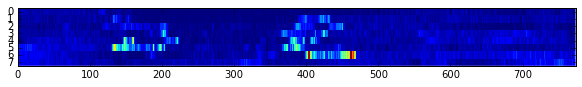

In [473]:
image_array = get_matrix(binned_data,len(bins),nScans)
plt.figure(figsize=(10,10))
plt.imshow(image_array[:,:,275],aspect=10,interpolation='None')

Create a document object to pass to LDA

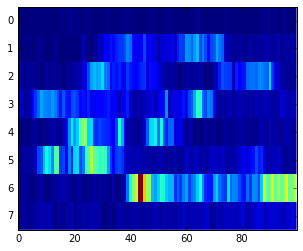

In [475]:
norm_max = 200 # all intensities are turned into integers between 0 and this value

# Define which image columns to look at
startcol = 360
endcol = 460

# Extract the sub image
sub_image = image_array[:,startcol:endcol,:]
# Plot it to check it is correct (275 will only work for b and e)
plt.imshow(sub_image[:,:,275],aspect=10,interpolation='None')

# Find the maximum intensity for normalisation
max_intensity = sub_image.max()

# Find the size of everything
nrows,ncols,nwords = sub_image.shape

words = []
for bin in range(len(bins)):
    words.append(str(bin))

# Create the corpus object to pass to LDA
# it is a dictionary of documents. Each document value is a dictionary of words where each word value is the count
corpus = {}

for row in range(nrows):
    for col in range(ncols):
        coord = (row,col)
        newdoc = {}
        for bin in range(len(bins)):
            if sub_image[row,col,bin] > 0:
                intensity = int(norm_max*1.0*sub_image[row,col,bin]/max_intensity)
                newdoc[words[bin]] = intensity
        corpus[coord] = newdoc
            


Create and run the LDA object
==

In [467]:
l = LDA(corpus)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [468]:
l.gibbs_iteration(n_samples=100,burn=True)
l.gibbs_iteration(n_samples=100,burn=False)

Sample 0 of 100 (Burn is True)
Sample 1 of 100 (Burn is True)
Sample 2 of 100 (Burn is True)
Sample 3 of 100 (Burn is True)
Sample 4 of 100 (Burn is True)
Sample 5 of 100 (Burn is True)
Sample 6 of 100 (Burn is True)
Sample 7 of 100 (Burn is True)
Sample 8 of 100 (Burn is True)
Sample 9 of 100 (Burn is True)
Sample 10 of 100 (Burn is True)
Sample 11 of 100 (Burn is True)
Sample 12 of 100 (Burn is True)
Sample 13 of 100 (Burn is True)
Sample 14 of 100 (Burn is True)
Sample 15 of 100 (Burn is True)
Sample 16 of 100 (Burn is True)
Sample 17 of 100 (Burn is True)
Sample 18 of 100 (Burn is True)
Sample 19 of 100 (Burn is True)
Sample 20 of 100 (Burn is True)
Sample 21 of 100 (Burn is True)
Sample 22 of 100 (Burn is True)
Sample 23 of 100 (Burn is True)
Sample 24 of 100 (Burn is True)
Sample 25 of 100 (Burn is True)
Sample 26 of 100 (Burn is True)
Sample 27 of 100 (Burn is True)
Sample 28 of 100 (Burn is True)
Sample 29 of 100 (Burn is True)
Sample 30 of 100 (Burn is True)
Sample 31 of 100 (

Draw images of each topics

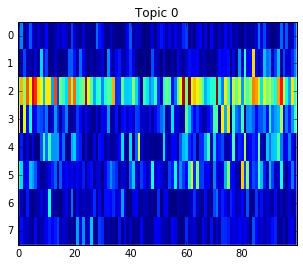

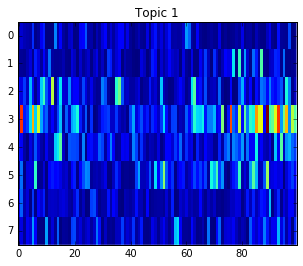

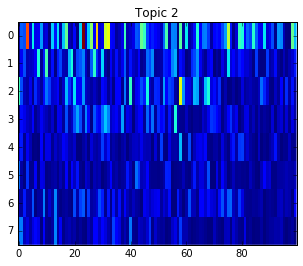

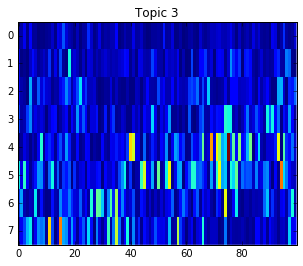

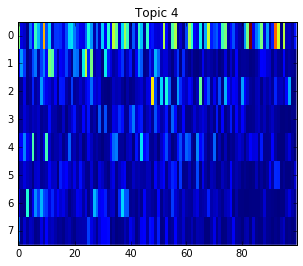

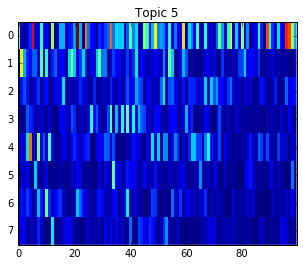

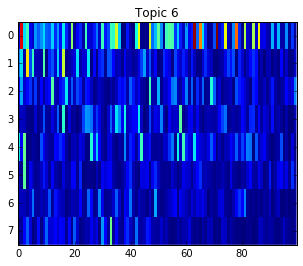

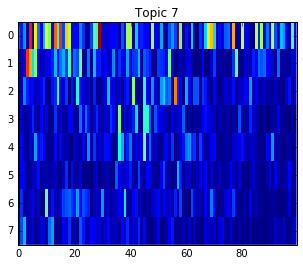

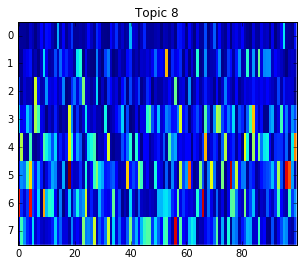

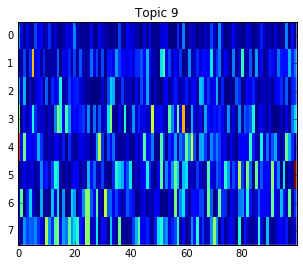

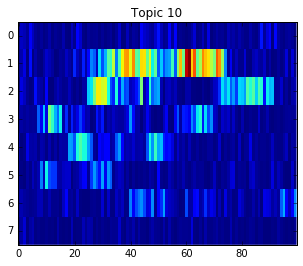

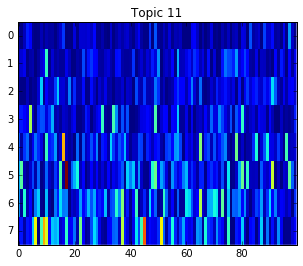

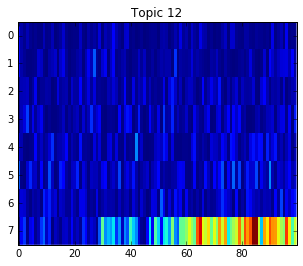

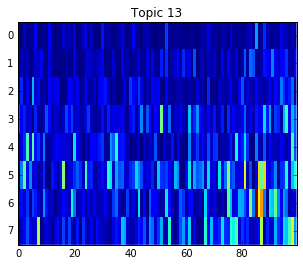

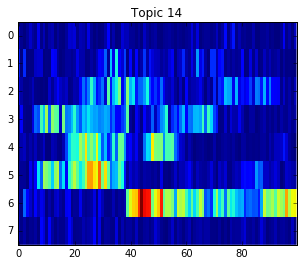

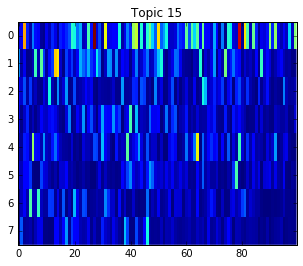

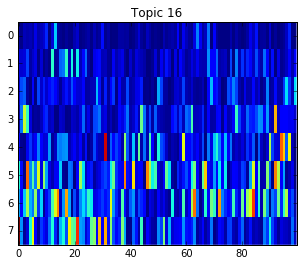

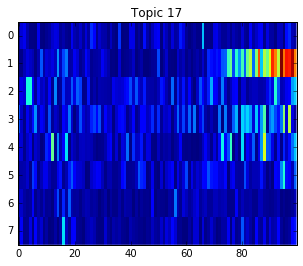

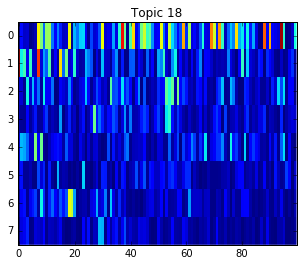

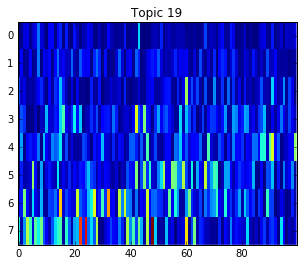

In [472]:
for topic in range(l.K):
    image_array = l.plot_topic(topic,nrows = nrows,ncols=ncols)
    plt.figure()
    plt.imshow(image_array,aspect=10,interpolation='None')
    plt.title('Topic {}'.format(topic))

Make a function to nicely display the peaks in a topic

In [493]:
def display_topic(topic_index,n_bins=10):
    plt.figure(figsize=(30,5))
    m,p = l.get_mass_plot(topic_index)
    plt.bar(m,p)
    plt.title('Topic {}'.format(topic_index))


    m_probs = zip(m,p)
    m_probs = sorted(m_probs,key=lambda x: x[1],reverse=True)
    for i in range(n_bins):
        m,p = m_probs[i]
        plt.figure()
        plt.imshow(sub_image[:,:,int(m)],aspect=10,interpolation='None')
        plt.title("Mass {}".format(int(m)))

Display the topics that seem to be associated with the letter 'e'
Each plot shows the masses in the topic as a bar plot and then draws images with the 10 most prevalent masses

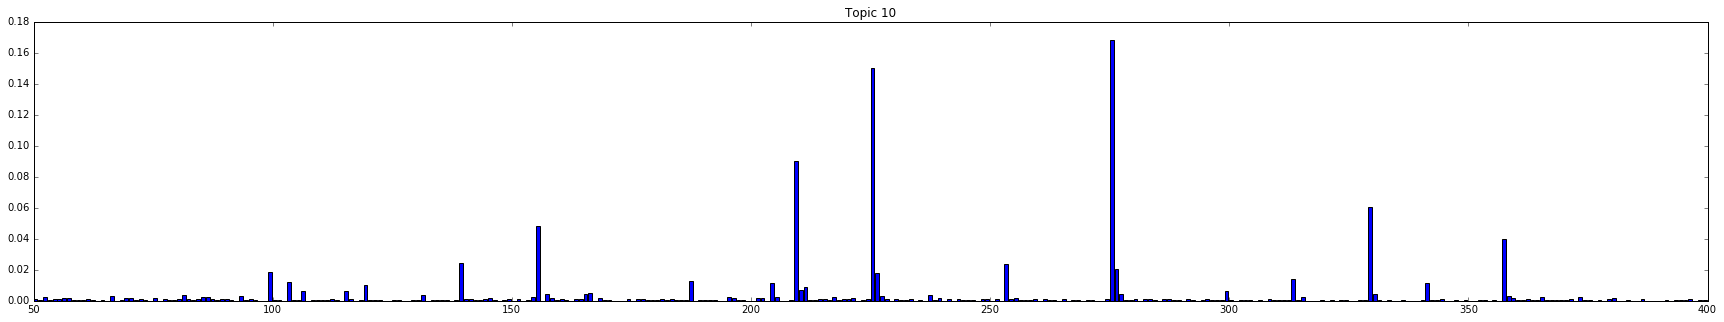

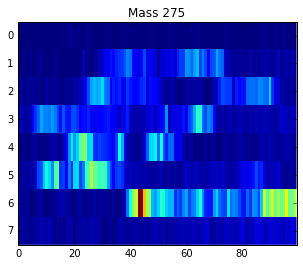

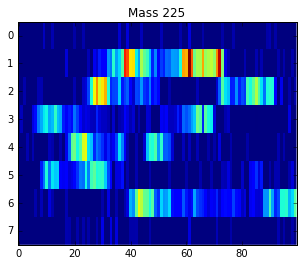

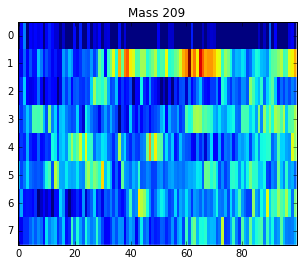

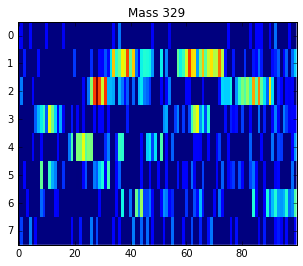

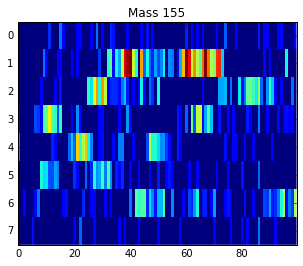

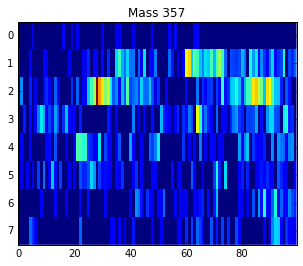

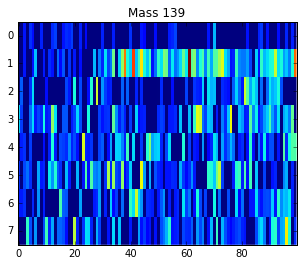

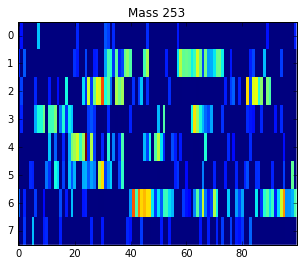

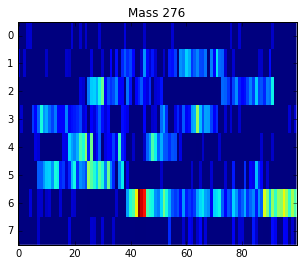

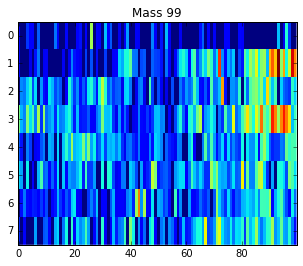

In [496]:
display_topic(10,n_bins=10)

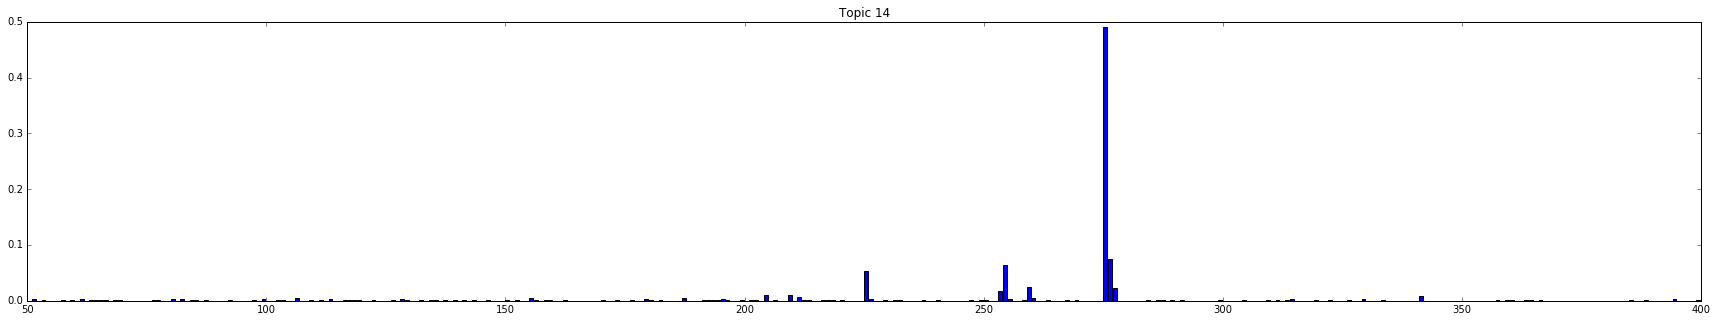

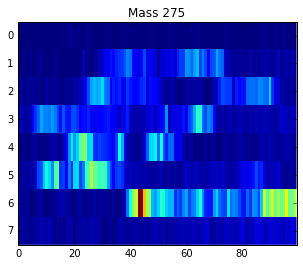

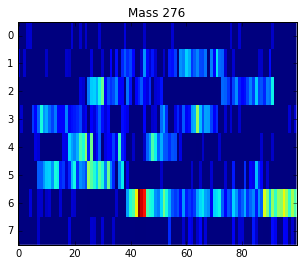

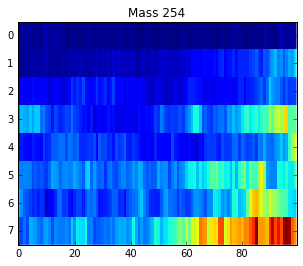

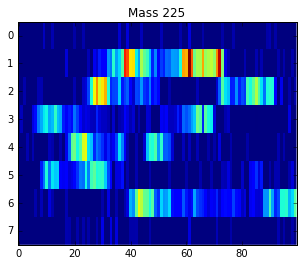

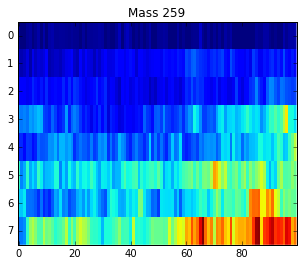

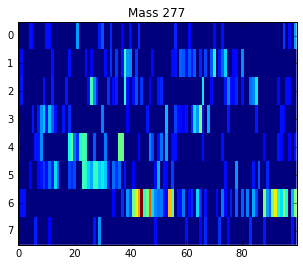

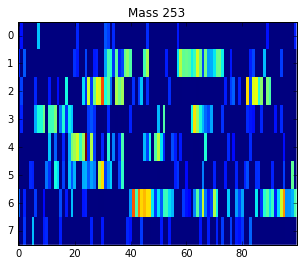

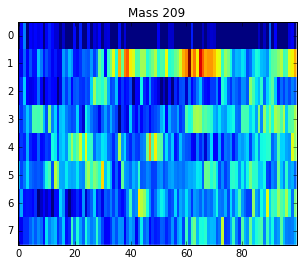

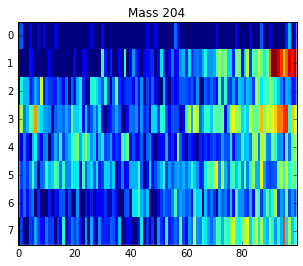

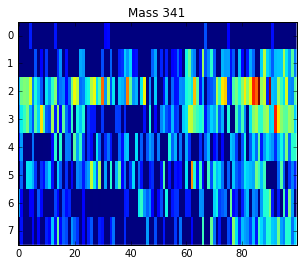

In [497]:
display_topic(14,n_bins=10)

Cell to save the current model

In [490]:
jp = jsonpickle.encode(l)

with open('letter_e_lda.txt','w') as f:
    f.write(jp)

Cell to load a model from file

In [ ]:
# with open('letter_e_lda.txt','r') as f:
#     jp = f.read()
l2 = jsonpickle.decode(jp)